# An EXP simulation using pyEXP from a notebook: a disk-halo simulation

This notebook uses `k3d` for three-dimensional respresentation of contours.  If you do not have `k3d`,  you will need to `pip install k3d` if you would like to see the three-dimensional views.  The Docker container has `k3d` preinstalled.

We begin by importing `pyEXP` and friends and setting the working directory.

In [1]:
import os
import yaml
import pyEXP
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 9]

os.chdir('DiskHalo')

# Print the current working directory for reference
print(os.getcwd())

/home/weinberg/Projects/pyEXP-examples/Tutorials/EXP/DiskHalo


## Running EXP

If you have a full EXP install or are using the Docker image, you can run EXP from inside Jupyter to generate new simulations.  We'll do
and example here using the periodic cube.

### Generating initial conditions

The full install has a body generator for the galaxy initial conditions called `gendisk`.   This code uses an Eddington inversion to
generate spherical halo initial condtions and Jeans equations to generate disk initial conditions.  It will generate the cylindrical
basis at the same time.  This step takes some time, so please be prepared to wait for 10 or 15 minutes.  Try it as follows:

In [2]:
! mpirun gendisk --ASCALE=0.01 --HSCALE=0.002 --scale_length=0.01 --scale_height=0.002 --LMAX=2 --MMAX=2 --NMAXH=6 --NMAXD=8 --NODD=2 --RMIN=0.0001 --nhalo=60000 --ndisk=20000 --ignore --cachefile=eof.cache.test

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%% Node, process, and communicator assignment %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
  Node # |             Hostname |      PID |     Status
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
       0 |                raven |   222347 |       ROOT
       1 |                raven |   222348 |    WORKER 0
       2 |                raven |   222349 |    WORKER 1
       3 |                raven |   222350 |    WORKER 2
       4 |                raven |   222351 |    WORKER 3
       5 |                raven |   222352 |    WORKER 4
       6 |                raven |   222353 |    WORKER 5
       7 |                raven |   222360 |    WORKER 6
       8 |                raven |   222362 |    WORKER 7
       9 |                raven |   222365 |    WORKER 8
      10 |                raven |   222368 |    WOR


A few comments on `gendisk` parameters used above:
- `ASCALE` is the scale length for the basis function construction
- `HSCALE` is the scale height for the basis function construction
- `scale_length` is the scale length for the particle distribution
- `scale_height` is the scale height for the particle distribution
- `LMAX` is the maximum spherical order for the halo
- `MMAX` is the maximum azimuthal order for the disk
- `NMAXH` is the maximum radial order for the halo
- `NMAXD` is the maximum radial order for the disk
- `NODD` is the number of vertically antisymmetric functions per azimuthal order
- `RMIN` is the minimum halo radius for internal tabulation
- `nhalo` is the number of desired halo particles
- `ndisk` is the number of desired disk particles
- `ignore` if true, disk basis cache file is recomputed and rewritted, even if it exists
- `cachefile` is the name of the disk basis cache file

It almost always makes sense to set the basis and distribution scale lengths and heights to the same values.  But you have the 
option to vary those.  You can view all of the possible parameters using `gendisk -h`, but these are the most often used ones and
the rest of sensible defaults for many cases.

### Running the simulation

We have provided a sample `exp` configuration file in this working directory.  The default name for a configuration file is
`config.yml`.  This run will take under an hour; and as little as 10 minutes on a modern laptop.  So be prepared to take a short
break.  For maximum speed change `X` in the `-np X` argument to `mpirun` to the number of cores available in your CPU.

The first shell command below empties the data directory, and the next is the`exp` launch command. The `exp` code will run for
500 steps.  You can estimate the total run time by looking at the last line of every step diagnostic stanza that estimates the
time needed for each part of the caluculation.  The 'Total' field is the total run time in seconds per step.  E.g. if your computer
is requiring 3 seconds per step, the completion time will be 25 minutes.

In [3]:
%%time
! rm data/*
! mpirun exp

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#   Node name           PID         Executable                              
-   ---------           ---         ----------                              
0   raven               224435      exp                                     
1   raven               224436      exp                                     
2   raven               224437      exp                                     
3   raven               224438      exp                                     
4   raven               224439      exp                                     
5   raven               224440      exp                                     
6   raven               224441      exp                                     
7   raven               224444      exp                                     
8   raven               224445      exp                                     
9   raven               224448      exp                                

## Read the log file

and plot the virial equilibrium as a function of time.  The log file records the center of mass, center of velocity, angular momentum,
and energies for the total and for each component separately.  Here, we will plot the virial statistic as a diagnostic for equilibrium.

In [4]:
!pwd
!ls data/OUTLOG.run0

/home/weinberg/Projects/pyEXP-examples/Tutorials/EXP/DiskHalo
data/OUTLOG.run0


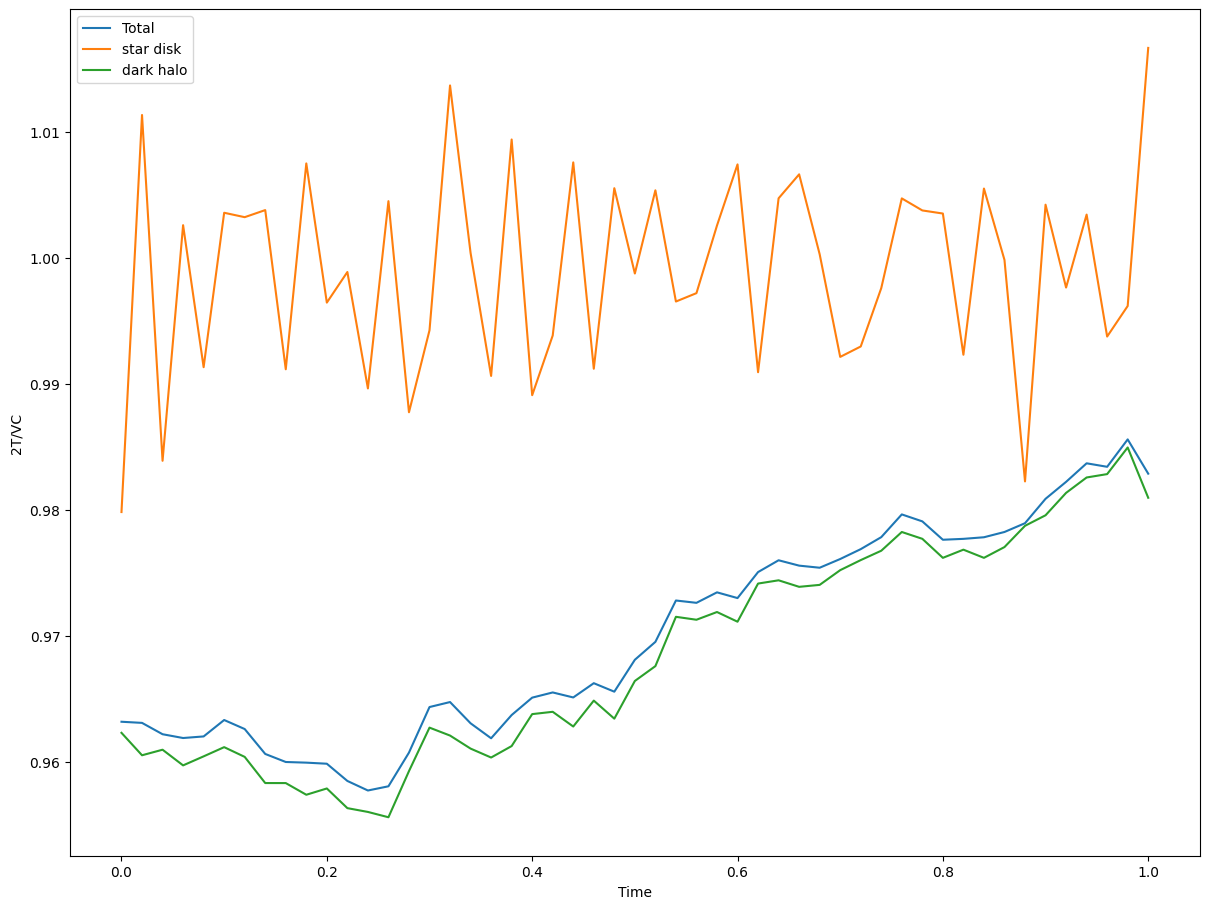

In [5]:
# This parses the  OUTLOG files generated by exp.  You can see available columns by printing the keys
# in the dictionary 'data'.  For this plot, we will only look at twice the ratio of kinetic energy to potential energy
# (estimated by the virial of Clausius).

def parseLog(runtag):
    path = 'data/OUTLOG.' + runtag
    file = open(path)
    # Get the column names
    labs = file.readlines()[2:3][0].split('|')
    # Get the data
    vals = np.loadtxt("data/OUTLOG." + runtag, delimiter='|', skiprows=6)
    # Make a dictionary of columns
    data = {}
    for i in range(len(labs)):
        data[labs[i].strip()] = vals[:,i]
    return data

# Get the dictionary
data = parseLog('run0')

# Make the plot
plt.plot(data['Time'], data['2T/VC'], label='Total')
plt.plot(data['Time'], data['star disk 2T/VC'], label = 'star disk')
plt.plot(data['Time'], data['dark halo 2T/VC'], label = 'dark halo')
plt.legend()
plt.tight_layout()
plt.xlabel('Time')
plt.ylabel('2T/VC')
plt.show()

## Reading the disk coefficients
This is a test of the coefficients created by the `EXP-examples/DiskHalo` run.

In [6]:
# Reread the coefs from the file.  These are new HDF5 coefficients sets.
#
coefs = pyEXP.coefs.Coefs.factory('data/outcoef.star disk.run0')

print("Got coefs for name=", coefs.getName())

Got coefs for name= star disk


### Now get the time vector and data tensor. Plot some coefficient series as a function of time.

In [7]:
times = coefs.Times()
data  = coefs.getAllCoefs()

print("The data sizes and coefficient orders are:")
print("M orders, N orders, Times:", data.shape)

The data sizes and coefficient orders are:
M orders, N orders, Times: (3, 8, 501)


### Finally, plot some coefficient values...

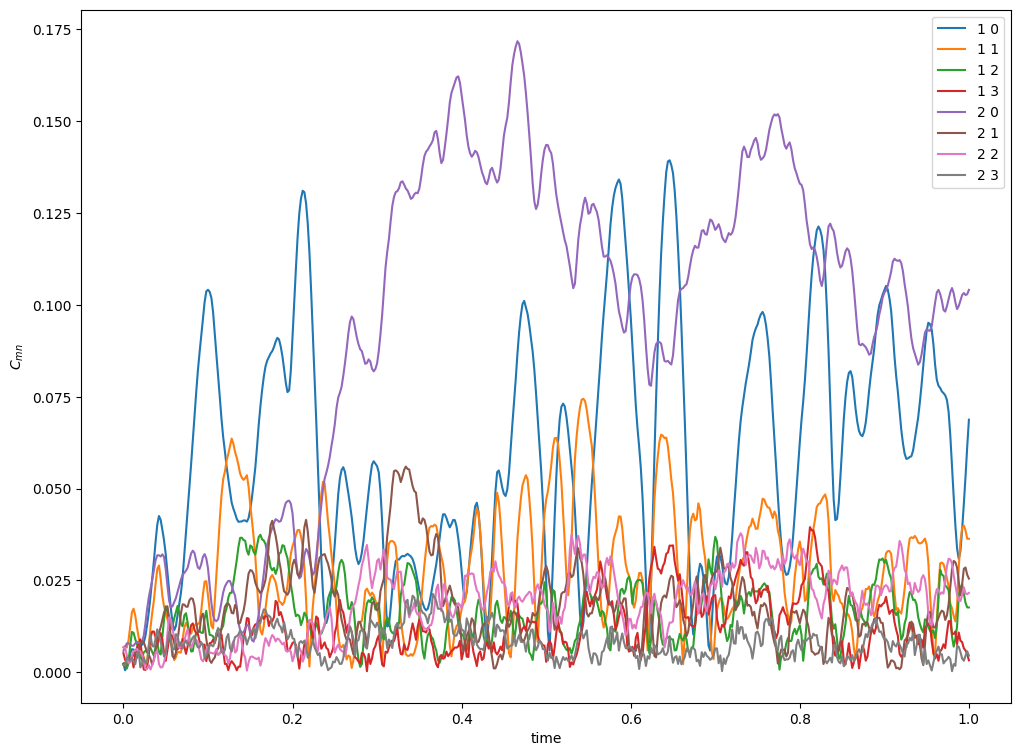

In [8]:
for m in range(1, data.shape[0]):
    for n in range(4):
        plt.plot(times, np.abs(data[m, n, :]), label='{} {}'.format(m, n))

plt.xlabel('time')
plt.ylabel(r'$C_{mn}$')
plt.legend()
plt.show()

## Try loading EXP config with pyYAML

In [9]:
with open('config.yml', 'r') as f:
    yaml_db = yaml.load(f, Loader=yaml.FullLoader)

# The 0 index force is the halo and the 1 index force is the disk, e.g.:
for i in range(2):
    print('Index {} is {}'.format(i, yaml_db['Components'][i]['name']))

config = yaml.dump(yaml_db['Components'][1]['force'])
        
print('\nIndex 1 config is:', config)

Index 0 is dark halo
Index 1 is star disk

Index 1 config is: id: cylinder
parameters:
  acyl: 0.01
  cachename: eof.cache.test
  hcyl: 0.002
  lmaxfid: 48
  mmax: 2
  ncylnx: 256
  ncylny: 128
  ncylodd: 2
  nmax: 8
  nmaxfid: 48



## Construct the cylindrical basis

In [10]:
basis = pyEXP.basis.Basis.factory(config)

---- EmpCylSL::ReadH5Cache: read <eof.cache.test>
---- EmpCylSL::read_cache: table forwarded to all processes
Cylindrical::orthoTest: worst=9.03892e-05


In [11]:
times = coefs.Times()

In [12]:
# Slice through the disk midplane
rmin  = -0.04
rmax  = 0.04
pmin  = [ rmin, rmin, 0]
pmax  = [ rmax, rmax, 0]
grid  = [   40,    40,  0]

fields = pyEXP.field.FieldGenerator(times, pmin, pmax, grid)

surfaces = fields.slices(basis, coefs)

The following routine rounds a value up in leading signficant figure (or down if the value is negative).  Just a
useful utility for setting contour levels on _nice_ numbers.

In [13]:
import math

def getLim(x):
    """ Get the one signifcant figure upper/lower limit """
    om = 10.0**np.floor(np.log10(np.abs(x)))
    if x < 0.0:
        return (np.floor(x/om)*om, om)
    else:
        return (np.ceil(x/om)*om, om)

In [14]:
densmin =  1.0e30
densmax = -1.0e30

for v in surfaces:
    for k in surfaces[v]: 
        if k=='dens':
            densmin = min(densmin, np.min(surfaces[v]['dens']))
            densmax = max(densmax, np.max(surfaces[v]['dens']))

print('Density range', densmin, densmax)

Density range -706.22186 55059.957


## Render the disk plane density slice

This next cell will write images to disk for making a movie.  It will take a few minutes to complete.

In [15]:
from matplotlib import cm, ticker

# Get the evaluation grid
dr = (rmax-rmin)/(40-1)
rr = np.arange(rmin, rmax+0.1*dr, dr)
xv, yv = np.meshgrid(rr, rr)
cnt = 0

# Round to one sig figfor v in surfaces:
dmax, ommax = getLim(math.log10(densmax))

# Make levels
levs = 10.0**np.arange(dmax-4, dmax+0.01, 0.25)

for v in times:
    mat = surfaces[v]['dens']
    mat[mat<levs[0]] = levs[0]
    cc = plt.contourf(xv, yv, mat.transpose(), levels=levs, locator=ticker.LogLocator())
    plt.colorbar(cc)
    plt.title('Time={:4.3f}'.format(v))
    plt.savefig('disk_{:04d}.png'.format(cnt))
    plt.close()
    cnt += 1

#### Make a movie from the rendered frames

This requires `ffmpeg` to be installed.  It *is* installed in the Docker image...

In [16]:
os.system('ffmpeg -y -i \'disk_%04d.png\' disk_{0}.mp4'.format('run0'))

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

0

#### Play the movie

In [17]:
from IPython.display import Video
Video('disk_{}.mp4'.format('run0'), embed=True, width=800)

### A few comments

This simulation was restricted low harmonic and radial orders for speed and owing to the small particle number.  Feel free to regenerate
the initial conditions with larger particle numbers and increase the number of basis function expansion terms to experiment with this.
It is best although not strictly necessary to match the maximum order chosen in the initial condition generation to the orders in
the `config.yml` file used to configure the simulation.

You may have noticed from the coefficient plot and the movie that the dipole component is prominent: the disk is affected by the dipole of the halo.  It is interesting to rerun the halo without the odd-order l harmonics.

### A 3d rendering for fun

Make the volume slices for the disk component

In [18]:
import k3d
from k3d import matplotlib_color_maps

# Slice through the cube perpendicular to the z axis
rmin  = -0.04
rmax  = 0.04
hmin  = -0.005
hmax  =  0.005
pmin  = [ rmin, rmin, hmin]
pmax  = [ rmax, rmax, hmax]
grid  = [   40,   40,   40]

# Only render the final time
fields = pyEXP.field.FieldGenerator(times[-1:], pmin, pmax, grid)

volumes = fields.volumes(basis, coefs)

Take the log of the density field and find some good contour levels

In [19]:
# levels for rendering 
dmax, ommax = getLim(math.log10(densmax))
llevs = np.arange(dmax-2, dmax+0.01, 0.5)
levs = 10.0**llevs
print("Level surfaces:", levs, llevs)

v = volumes[times[-1]]['dens']
v[v<levs[0]] = 0.5*levs[0]
v = np.log10(v)

Level surfaces: [  1000.           3162.27766017  10000.          31622.77660168
 100000.        ] [3.  3.5 4.  4.5 5. ]


Finally, make the 3d rendering using `k3d`

In [20]:
plot = k3d.plot(axes=['z', 'y', 'x'])
color_map = k3d.basic_color_maps.Jet

minlev = dmax-2.0
maxlev = dmax

for lev in llevs:
    plot += k3d.marching_cubes(v, level=lev, attribute=[lev], color_map=color_map, color_range=[minlev, maxlev],
                            opacity=0.25,
                            xmin=hmin, xmax=hmax,
                            ymin=rmin, ymax=rmax,
                            zmin=rmin, zmax=rmax,
                            compression_level=9,
                            flat_shading=False)
plot.display()
plot.camera = [0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 1, 0, 0]



Output()

### Visualizing the halo wake

We can repeat the same rendering for the halo to see the wake induced by the bar!

First, we need to create the halo basis and read the halo coefficients.

In [21]:
halo_config = yaml.dump(yaml_db['Components'][0]['force'])
halo_basis = pyEXP.basis.Basis.factory(halo_config)
halo_coefs = pyEXP.coefs.Coefs.factory('data/outcoef.dark halo.run0')

---- SLGridSph::ReadH5Cache: successfully read basis cache <sphereSL.cache.test>
Spherical::orthoTest: worst=0.00990365


In [22]:
coef_data = halo_coefs.getAllCoefs()

# Let's zero all of the odd order data
for k in range(coef_data.shape[0]):
    l, m = pyEXP.basis.SphericalSL.invI(k)
    if l%2!=0 or m%2!=0: coef_data[k,:,:] *= 0.0

# Reset the coefficient data
for i in range(coef_data.shape[2]):
    halo_coefs.setMatrix(times[i], coef_data[:,:,i])

Now, we can render the volume resconstruction for a cube around the disk with same extent as the disk rendering.

In [23]:
rmin  = -0.04
rmax  =  0.04
pmin  = [ rmin, rmin, rmin]
pmax  = [ rmax, rmax, rmax]
grid  = [   40,   40,   40]

# Only render the final time
halo_fields = pyEXP.field.FieldGenerator(times[-1:], pmin, pmax, grid)

halo_volumes = halo_fields.volumes(halo_basis, halo_coefs)

To emphasize the wake, we'll render the non-spherical components only

In [24]:
# Get the non-axisymmetric density

v = halo_volumes[times[-1]]['dens m>0']
dmin = np.min(v)
dmax = np.max(v)

print('Density range', dmin, dmax)

# levels for rendering 
drange = (dmax - dmin)/6
levs = np.arange(dmin, dmax+0.01*drange, drange)

print("Level surfaces:", levs)

plot2 = k3d.plot(axes=['z', 'y', 'x'])
color_map = k3d.basic_color_maps.Jet

for lev in levs:
    plot2 += k3d.marching_cubes(v, level=lev, attribute=[lev], color_map=color_map, color_range=[levs[0], levs[-1]],
                            opacity=0.25,
                            xmin=rmin, xmax=rmax,
                            ymin=rmin, ymax=rmax,
                            zmin=rmin, zmax=rmax,
                            compression_level=9,
                            flat_shading=False)
plot2.display()
plot2.camera = [0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 1, 0, 0]

Density range -96.61719 81.653275
Level surfaces: [-96.6171875  -66.90544383 -37.19370015  -7.48195648  22.22978719
  51.94153086  81.65327454]


Output()